In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==================================================
# 0. 의존성
# ==================================================
import os, json, random
from glob import glob
from collections import defaultdict
from typing import List, Tuple, Dict

from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from tqdm.auto import tqdm

# ==================================================
# 1. 전역 설정
# ==================================================
ROOT_DIR    = "/content/drive/MyDrive/Data/MVTecAD"
BATCH_SIZE  = 2
NUM_WORKERS = 4
LR = 1e-4
EPOCHS = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ==================================================
# 2. COCO JSON 파싱 → {file_name: [[x1,y1,x2,y2], ...]}
# ==================================================
def parse_coco_json(json_path: str) -> Dict[str, List[List[float]]]:
    with open(json_path) as f:
        coco = json.load(f)

    id_to_name = {img["id"]: img["file_name"] for img in coco["images"]}

    fname2boxes = defaultdict(list)
    for ann in coco["annotations"]:
        x, y, w, h = ann["bbox"]
        box = [x, y, x + w, y + h]
        fname2boxes[id_to_name[ann["image_id"]]].append(box)

    return fname2boxes

# ==================================================
# 3. Dataset
# ==================================================
class MVTecODDataset(Dataset):
    """
    test/<defect>/ 이미지 ↔ ground_truth/<defect>/COCO-json(1개)
    """
    def __init__(self, root_dir: str, transforms=None, use_good: bool=False):
        self.root_dir   = root_dir
        self.transforms = transforms
        self.samples: List[Tuple[str, List[List[float]], int]] = []
        self.label_map: Dict[str, int] = {}
        lbl_idx = 1   # 0 = background

        for category in sorted(os.listdir(root_dir)):
            cat_dir = os.path.join(root_dir, category)
            if not os.path.isdir(cat_dir):
                continue

            test_dir = os.path.join(cat_dir, "test")
            gt_dir   = os.path.join(cat_dir, "ground_truth")
            if not (os.path.isdir(test_dir) and os.path.isdir(gt_dir)):
                continue

            for defect in sorted(os.listdir(test_dir)):
                if defect == "good" and not use_good:
                    continue

                img_dir  = os.path.join(test_dir, defect)
                ann_json = glob(os.path.join(gt_dir, defect, "*.json"))
                if len(ann_json) != 1:
                    print(f"[경고] {category}/{defect} JSON 수={len(ann_json)} → 스킵")
                    continue

                # label id 부여
                if defect not in self.label_map:
                    self.label_map[defect] = lbl_idx
                    lbl_idx += 1
                label_id = self.label_map[defect]

                # COCO JSON → fname➜boxes
                fname2boxes = parse_coco_json(ann_json[0])

                for fname, boxes in fname2boxes.items():
                    # --- 원본 이미지 경로 찾기 -----------------------------
                    base = fname.replace("_mask", "")
                    cand = [os.path.join(img_dir, base),
                            os.path.join(img_dir, base[:-4] + ".png"),
                            os.path.join(img_dir, base[:-4] + ".jpg"),
                            os.path.join(img_dir, fname)]     # 마스크 자체
                    img_path = next((p for p in cand if os.path.isfile(p)), None)
                    if img_path is None:
                        continue
                    # ------------------------------------------------------
                    self.samples.append((img_path, boxes, label_id))

        print(f"총 {len(self.samples)}개 이미지,  라벨 맵: {self.label_map}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, boxes, label_id = self.samples[idx]

        img    = Image.open(img_path).convert("RGB")
        boxes  = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.full((len(boxes),), label_id, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target, img_path   # ← 경로도 함께 반환

# ==================================================
# 4. collate_fn & DataLoader
# ==================================================
def collate_fn(batch):
    imgs, targets, paths = zip(*batch)
    return list(imgs), list(targets), list(paths)

dataset = MVTecODDataset(ROOT_DIR,
                         transforms=lambda x: F.to_tensor(x),
                         use_good=False)

data_loader = DataLoader(dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=NUM_WORKERS,
                         collate_fn=collate_fn,
                         pin_memory=True)


device: cuda
[경고] cable/.DS_Store JSON 수=0 → 스킵
[경고] metal_nut/.DS_Store JSON 수=0 → 스킵
총 1258개 이미지,  라벨 맵: {'broken_large': 1, 'broken_small': 2, 'contamination': 3, 'bent_wire': 4, 'cable_swap': 5, 'combined': 6, 'cut_inner_insulation': 7, 'cut_outer_insulation': 8, 'missing_cable': 9, 'missing_wire': 10, 'poke_insulation': 11, 'crack': 12, 'faulty_imprint': 13, 'poke': 14, 'scratch': 15, 'squeeze': 16, 'color': 17, 'cut': 18, 'hole': 19, 'metal_contamination': 20, 'thread': 21, 'bent': 22, 'broken': 23, 'glue': 24, 'print': 25, 'fold': 26, 'flip': 27, 'pill_type': 28, 'manipulated_front': 29, 'scratch_head': 30, 'scratch_neck': 31, 'thread_side': 32, 'thread_top': 33, 'glue_strip': 34, 'gray_stroke': 35, 'oil': 36, 'rough': 37, 'defective': 38, 'bent_lead': 39, 'cut_lead': 40, 'damaged_case': 41, 'misplaced': 42, 'liquid': 43, 'broken_teeth': 44, 'fabric_border': 45, 'fabric_interior': 46, 'split_teeth': 47, 'squeezed_teeth': 48}


In [ ]:
# --------------------------------------------------
# 5. Dataset 인스턴스 생성
# --------------------------------------------------
dataset = MVTecODDataset(
    ROOT_DIR,
    transforms=lambda x: F.to_tensor(x),
    use_good=False
)

# --------------------------------------------------
# 6. train / val split ─ random_split
# --------------------------------------------------
train_ratio = 0.8
n_total     = len(dataset)
n_train     = int(train_ratio * n_total)
n_val       = n_total - n_train

train_set, val_set = torch.utils.data.random_split(
    dataset,
    [n_train, n_val],
    generator=torch.Generator()   # 재현 가능
)

print(f"train: {len(train_set)} / val: {len(val_set)}")

# --------------------------------------------------
# 7. DataLoader 설정
# --------------------------------------------------
def collate_fn(batch):
    imgs, targets, paths = zip(*batch)
    return list(imgs), list(targets), list(paths)

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,          # 검증은 셔플 X
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)

# --------------------------------------------------
# 8. 간단 테스트 루프
# --------------------------------------------------
for phase, loader in [("train", train_loader), ("val", val_loader)]:
    imgs, targets, paths = next(iter(loader))
    print(f"[{phase}]  첫 경로:", paths[0])
    print(f"[{phase}]  첫 bbox:", targets[0]["boxes"][0])

[경고] cable/.DS_Store JSON 수=0 → 스킵
[경고] metal_nut/.DS_Store JSON 수=0 → 스킵
총 1258개 이미지,  라벨 맵: {'broken_large': 1, 'broken_small': 2, 'contamination': 3, 'bent_wire': 4, 'cable_swap': 5, 'combined': 6, 'cut_inner_insulation': 7, 'cut_outer_insulation': 8, 'missing_cable': 9, 'missing_wire': 10, 'poke_insulation': 11, 'crack': 12, 'faulty_imprint': 13, 'poke': 14, 'scratch': 15, 'squeeze': 16, 'color': 17, 'cut': 18, 'hole': 19, 'metal_contamination': 20, 'thread': 21, 'bent': 22, 'broken': 23, 'glue': 24, 'print': 25, 'fold': 26, 'flip': 27, 'pill_type': 28, 'manipulated_front': 29, 'scratch_head': 30, 'scratch_neck': 31, 'thread_side': 32, 'thread_top': 33, 'glue_strip': 34, 'gray_stroke': 35, 'oil': 36, 'rough': 37, 'defective': 38, 'bent_lead': 39, 'cut_lead': 40, 'damaged_case': 41, 'misplaced': 42, 'liquid': 43, 'broken_teeth': 44, 'fabric_border': 45, 'fabric_interior': 46, 'split_teeth': 47, 'squeezed_teeth': 48}
train: 1006 / val: 252
[train]  첫 경로: /content/drive/MyDrive/Data/M

In [ ]:
# ==================================================
# 9. Object Detection 학습 스크립트
# ==================================================
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from tqdm.auto import tqdm

# ─────────────── 9-1. 모델 준비 ───────────────
num_classes = len(dataset.label_map) + 1   # +1 = background

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
# classifier 헤드 교체
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

# ─────────────── 9-2. 옵티마이저·스케줄러 ───────────────
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=LR, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# ─────────────── 9-3. 학습 & 검증 루프 ───────────────
def train_one_epoch(model, loader):
    model.train()
    epoch_loss = 0.0

    for imgs, targets, _ in tqdm(loader, desc="train", leave=False):
        imgs     = [img.to(device) for img in imgs]
        targets  = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    return epoch_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader):
    val_loss = 0.0

    for imgs, targets, _ in loader:
        imgs    = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)       # ← dict 반환
        val_loss += sum(loss_dict.values()).item()

    return val_loss / len(loader)

In [ ]:
# ─────────────── 9-4. 메인 루프 ───────────────
best_val = float("inf")
ckpt_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader)
    val_loss   = evaluate(model,   val_loader)

    lr_scheduler.step()

    print(f"[{epoch+1:02}/{EPOCHS}]  "
          f"train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f}")

    # 가장 낮은 val loss 모델 저장
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(),
                   os.path.join(ckpt_dir, f"fasterrcnn_best.pth"))
        print("  ↳ 🎉  New best model saved!")

print("Training complete. Best val loss:", best_val)

train:   0%|          | 0/503 [00:00<?, ?it/s]

[01/50]  train_loss: 0.3356 | val_loss: 0.2709
  ↳ 🎉  New best model saved!


train:   0%|          | 0/503 [00:00<?, ?it/s]

[02/50]  train_loss: 0.2757 | val_loss: 0.2968


train:   0%|          | 0/503 [00:00<?, ?it/s]

[03/50]  train_loss: 0.2472 | val_loss: 0.2599
  ↳ 🎉  New best model saved!


train:   0%|          | 0/503 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[04/50]  train_loss: 0.2176 | val_loss: 0.2399
  ↳ 🎉  New best model saved!


train:   0%|          | 0/503 [00:00<?, ?it/s]

[05/50]  train_loss: 0.2056 | val_loss: 0.2327
  ↳ 🎉  New best model saved!


train:   0%|          | 0/503 [00:00<?, ?it/s]

[06/50]  train_loss: 0.1810 | val_loss: 0.2221
  ↳ 🎉  New best model saved!


train:   0%|          | 0/503 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[07/50]  train_loss: 0.1704 | val_loss: 0.2276


train:   0%|          | 0/503 [00:00<?, ?it/s]

[08/50]  train_loss: 0.1552 | val_loss: 0.2113
  ↳ 🎉  New best model saved!


train:   0%|          | 0/503 [00:00<?, ?it/s]

[09/50]  train_loss: 0.1437 | val_loss: 0.2048
  ↳ 🎉  New best model saved!


train:   0%|          | 0/503 [00:00<?, ?it/s]

[10/50]  train_loss: 0.1283 | val_loss: 0.2124


train:   0%|          | 0/503 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
    if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
     File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
 Exception ignored in: ^    <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>if w.is_alive():^
^ 
^ ^ Traceback (most recent call last):
^   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.

[11/50]  train_loss: 0.1059 | val_loss: 0.1960
  ↳ 🎉  New best model saved!


train:   0%|          | 0/503 [00:00<?, ?it/s]

[12/50]  train_loss: 0.0814 | val_loss: 0.2056


train:   0%|          | 0/503 [00:00<?, ?it/s]

[13/50]  train_loss: 0.0704 | val_loss: 0.2098


train:   0%|          | 0/503 [00:00<?, ?it/s]

[14/50]  train_loss: 0.0626 | val_loss: 0.2134


train:   0%|          | 0/503 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
          Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^

[15/50]  train_loss: 0.0556 | val_loss: 0.2201


train:   0%|          | 0/503 [00:00<?, ?it/s]

[16/50]  train_loss: 0.0507 | val_loss: 0.2259


train:   0%|          | 0/503 [00:00<?, ?it/s]

[17/50]  train_loss: 0.0467 | val_loss: 0.2286


train:   0%|          | 0/503 [00:00<?, ?it/s]

[18/50]  train_loss: 0.0430 | val_loss: 0.2325


train:   0%|          | 0/503 [00:00<?, ?it/s]

[19/50]  train_loss: 0.0408 | val_loss: 0.2333


train:   0%|          | 0/503 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>  
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
 Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>^
^self._shutdown_workers()^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__


[20/50]  train_loss: 0.0390 | val_loss: 0.2390


train:   0%|          | 0/503 [00:00<?, ?it/s]

[21/50]  train_loss: 0.0352 | val_loss: 0.2404


train:   0%|          | 0/503 [00:00<?, ?it/s]

[22/50]  train_loss: 0.0324 | val_loss: 0.2406


train:   0%|          | 0/503 [00:00<?, ?it/s]

[23/50]  train_loss: 0.0310 | val_loss: 0.2396


train:   0%|          | 0/503 [00:00<?, ?it/s]

[24/50]  train_loss: 0.0301 | val_loss: 0.2430


train:   0%|          | 0/503 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00><function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00><function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()    self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  F

[25/50]  train_loss: 0.0291 | val_loss: 0.2435


train:   0%|          | 0/503 [00:00<?, ?it/s]

[26/50]  train_loss: 0.0285 | val_loss: 0.2431


train:   0%|          | 0/503 [00:00<?, ?it/s]

[27/50]  train_loss: 0.0280 | val_loss: 0.2434


train:   0%|          | 0/503 [00:00<?, ?it/s]

[28/50]  train_loss: 0.0274 | val_loss: 0.2453


train:   0%|          | 0/503 [00:00<?, ?it/s]

[29/50]  train_loss: 0.0268 | val_loss: 0.2465


train:   0%|          | 0/503 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00><function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()    

[30/50]  train_loss: 0.0265 | val_loss: 0.2463


train:   0%|          | 0/503 [00:00<?, ?it/s]

[31/50]  train_loss: 0.0256 | val_loss: 0.2477


train:   0%|          | 0/503 [00:00<?, ?it/s]

[32/50]  train_loss: 0.0259 | val_loss: 0.2492


train:   0%|          | 0/503 [00:00<?, ?it/s]

[33/50]  train_loss: 0.0256 | val_loss: 0.2491


train:   0%|          | 0/503 [00:00<?, ?it/s]

[34/50]  train_loss: 0.0256 | val_loss: 0.2496


train:   0%|          | 0/503 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>Exception ignored in: 

Traceback (most recent call last):
Traceback (most recent call last):
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
         self._shutdown_wor

[35/50]  train_loss: 0.0254 | val_loss: 0.2498


train:   0%|          | 0/503 [00:00<?, ?it/s]

[36/50]  train_loss: 0.0254 | val_loss: 0.2492


train:   0%|          | 0/503 [00:00<?, ?it/s]

[37/50]  train_loss: 0.0254 | val_loss: 0.2497


train:   0%|          | 0/503 [00:00<?, ?it/s]

[38/50]  train_loss: 0.0254 | val_loss: 0.2503


train:   0%|          | 0/503 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    Exception ignored in:     self._shutdown_workers()if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Exception ignored in: 
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdo

[39/50]  train_loss: 0.0257 | val_loss: 0.2508


train:   0%|          | 0/503 [00:00<?, ?it/s]

[40/50]  train_loss: 0.0252 | val_loss: 0.2513


train:   0%|          | 0/503 [00:00<?, ?it/s]

[41/50]  train_loss: 0.0254 | val_loss: 0.2515


train:   0%|          | 0/503 [00:00<?, ?it/s]

[42/50]  train_loss: 0.0253 | val_loss: 0.2513


train:   0%|          | 0/503 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^
^    Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>^  File "/u

[43/50]  train_loss: 0.0251 | val_loss: 0.2505


train:   0%|          | 0/503 [00:00<?, ?it/s]

[44/50]  train_loss: 0.0253 | val_loss: 0.2508


train:   0%|          | 0/503 [00:00<?, ?it/s]

[45/50]  train_loss: 0.0252 | val_loss: 0.2511


train:   0%|          | 0/503 [00:00<?, ?it/s]

[46/50]  train_loss: 0.0249 | val_loss: 0.2515


train:   0%|          | 0/503 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7d300f7bec00>

[47/50]  train_loss: 0.0250 | val_loss: 0.2506


train:   0%|          | 0/503 [00:00<?, ?it/s]

[48/50]  train_loss: 0.0253 | val_loss: 0.2511


train:   0%|          | 0/503 [00:00<?, ?it/s]

[49/50]  train_loss: 0.0249 | val_loss: 0.2519


train:   0%|          | 0/503 [00:00<?, ?it/s]

[50/50]  train_loss: 0.0252 | val_loss: 0.2509
Training complete. Best val loss: 0.19602438701050623


/usr/local/lib/python3.11/dist-packages/torchvision/utils.py:233: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


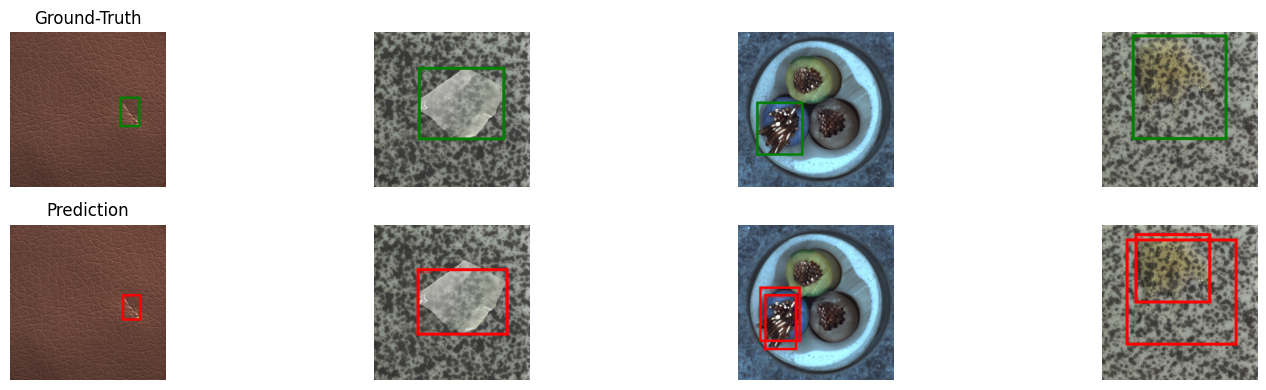

In [ ]:
# ==================================================
# 10. 시각화: 예측 ↔ GT 비교
# ==================================================
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as TF

# id → 이름 역매핑  (→ draw_bounding_boxes 의 labels 인자에 사용)
id2name = {v: k for k, v in dataset.label_map.items()}

def vis_predictions(model, loader, device,
                    score_thresh: float = 0.5,
                    num_images: int = 4):
    """
    • 검증 배치에서 num_images 장을 골라
      └ 왼쪽 : Ground-Truth (GREEN)
      └ 오른쪽: Prediction (RED, score ≥ thresh)
    """
    model.eval()
    shown = 0
    plt.figure(figsize=(num_images * 4, 4))

    with torch.no_grad():
        for imgs, targets, paths in loader:
            imgs = [img.to(device) for img in imgs]
            outputs = model(imgs)

            for img, tgt, pred in zip(imgs, targets, outputs):
                # ----------------- GT 그리기 -----------------
                gt_boxes  = tgt["boxes"].cpu()
                gt_labels = [id2name[int(l)] for l in tgt["labels"]]
                gt_img = draw_bounding_boxes(
                    (img.cpu() * 255).byte(),
                    gt_boxes,
                    labels=gt_labels,
                    colors="green",
                    width=16,          # ← 굵기 UP (기본 1)
                    font_size=18      # ← 글자 크기 UP (기본 10)
                )
                # ----------------- Pred 그리기 ----------------
                keep = pred["scores"] >= score_thresh
                pred_boxes  = pred["boxes"][keep].cpu()
                pred_labels = [id2name[int(l)]
                               for l in pred["labels"][keep]]
                pred_scores = pred["scores"][keep].cpu().tolist()
                # 라벨 뒤에 점수 표기
                pred_labels = [f"{lab}:{s:.2f}"
                               for lab, s in zip(pred_labels, pred_scores)]

                pred_img = draw_bounding_boxes(
                    (img.cpu() * 255).byte(),
                    pred_boxes,
                    labels=pred_labels,
                    colors="red",
                    width=16,          # ← 동일하게 굵기·글자 크기 조정
                    font_size=18
                )

                # ----------------- 시각화 ---------------------
                gt_np   = TF.to_pil_image(gt_img)
                pred_np = TF.to_pil_image(pred_img)

                plt.subplot(2, num_images, shown + 1)
                plt.imshow(gt_np);   plt.axis("off")
                if shown == 0: plt.title("Ground-Truth", fontsize=12)

                plt.subplot(2, num_images, num_images + shown + 1)
                plt.imshow(pred_np); plt.axis("off")
                if shown == 0: plt.title("Prediction", fontsize=12)

                shown += 1
                if shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return

# --------------------------------------------------
# 11. 가장 좋은 모델 weight 로드 후 시각화
# --------------------------------------------------
best_ckpt = "/content/drive/MyDrive/checkpoints/fasterrcnn_best.pth"
model.load_state_dict(torch.load(best_ckpt, map_location=device))
vis_predictions(model, val_loader, device,
                score_thresh=0.5, num_images=4)
